<a href="https://colab.research.google.com/github/AmelxJamal/STEM-Away-Internship/blob/master/Notebook_STEM_Away.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General Imports and Installations

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 4.2 MB/s 
     |████████████████████████████████| 4.7 MB 54.8 MB/s 
     |████████████████████████████████| 1.3 MB 51.9 MB/s 
     |████████████████████████████████| 120 kB 73.6 MB/s 
     |████████████████████████████████| 6.6 MB 53.0 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=8f8191370d543bda0a5df7de4d28d7e179bed343b22b8a5f87ad7467b4c3ac8a
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


# Kaggle Quora Dataset

In [3]:
!pip install kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 6.3 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=1f223bdf9f93fe57781ac32c05dac1ca7558d03ac107b8fd8a4f88b2dd6a8c46
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [4]:
!mkdir ~/.kaggle

In [5]:
!cp /content/kaggle.json /root/.kaggle

In [6]:
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
import os
os.environ["KAGGLE_CONFIG_"] =' /content/kaggle.json'

In [8]:
!kaggle competitions download -c quora-question-pairs

 96% 296M/309M [00:04<00:00, 55.5MB/s]
100% 309M/309M [00:04<00:00, 78.2MB/s]


In [9]:
!unzip /content/quora-question-pairs.zip

Archive:  /content/quora-question-pairs.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv                
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [10]:
!unzip /content/train.csv.zip

Archive:  /content/train.csv.zip
  inflating: train.csv               


In [11]:
train_df = pd.read_csv('/content/train.csv')
train_df.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [12]:
test_df = pd.read_csv('/content/test.csv')
test_df.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


# Retrieval System

In [14]:
x = train_df[['id', 'qid1', 'qid2', 'question1', 'question2']]
y = train_df.is_duplicate
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.998, random_state = 0)

In [15]:
x_train.shape

(808, 5)

In [16]:
import json
from sentence_transformers import SentenceTransformer, CrossEncoder, util
import gzip
import os
import torch
import pandas as pd

if not torch.cuda.is_available():
    print("Warning: No GPU found. Please add GPU to your notebook")


#We use the Bi-Encoder to encode all passages, so that we can use it with sematic search
# bi_encoder = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
bi_encoder = SentenceTransformer('all-mpnet-base-v2')

bi_encoder.max_seq_length = 256     #Truncate long passages to 256 tokens
top_k = 32                          #Number of passages we want to retrieve with the bi-encoder

#The bi-encoder will retrieve 100 documents. We use a cross-encoder, to re-rank the results list to improve the quality
# cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
cross_encoder = CrossEncoder('distilroberta-base', num_labels=1)
# cross_encoder = CrossEncoder('cross-encoder/quora-distilroberta-base')

# df = pd.read_csv('Questions.csv') --> kaggle dataset
# passages = df.body[:9000].to_numpy()


qoura = x_train.question1.to_numpy()
passages = qoura
print("Passages:", len(passages))

# We encode all passages into our vector space. This takes about 5 minutes (depends on your GPU speed)
corpus_embeddings = bi_encoder.encode(passages, convert_to_tensor=True, show_progress_bar=True)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.bias

Passages: 808


Batches:   0%|          | 0/26 [00:00<?, ?it/s]

In [17]:
corpus_embeddings[0].shape

torch.Size([768])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


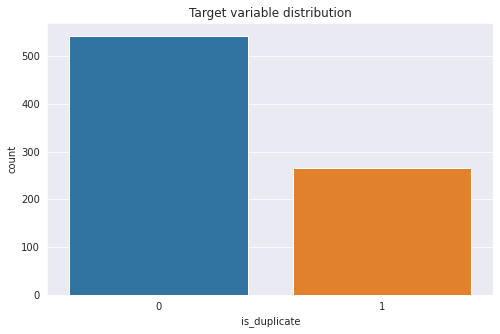

In [18]:
# Target variable distribution
train_sampled = x_train
train_sampled['is_duplicate'] = y_train
sns.set_style('darkgrid')
plt.figure(figsize=(8, 5))
sns.countplot(train_sampled["is_duplicate"])
plt.title('Target variable distribution')
plt.show()

In [19]:
# This function will search the corpus for passages that match the query
def search(query, top=3):
   
    ##### Sematic Search #####
    # Encode the query using the bi-encoder and find potentially relevant passages
    question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
    question_embedding = question_embedding.cuda()
    hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=top_k)
    hits = hits[0]  # Get the hits for the first query

    ##### Re-Ranking #####
    # Now, score all retrieved passages with the cross_encoder
    cross_inp = [[query, passages[hit['corpus_id']]] for hit in hits]
    cross_scores = cross_encoder.predict(cross_inp)

    # Sort results by the cross-encoder scores
    for idx in range(len(cross_scores)):
        hits[idx]['cross-score'] = cross_scores[idx]

    # Output of top-k hits from bi-encoder
    
    bi_encoder_hits = sorted(hits, key=lambda x: x['score'], reverse=True)
    
    bi_list, scores = [],[]
    for hit in bi_encoder_hits[0:top]:
        bi_list.append(passages[hit['corpus_id']])
        scores.append(hit['score'])

    # Output of top-k hits from re-ranker
   
    cross_encoder_hits = sorted(bi_encoder_hits, key=lambda x: x['cross-score'], reverse=True)
    cross_list, scores_cross = [], []
    for hit in cross_encoder_hits[0:3]:
        cross_list.append((passages[hit['corpus_id']]))
        scores_cross.append(hit['cross-score'])
    return bi_list, cross_list, scores, scores_cross

In [20]:
from collections import defaultdict
def compute_hits(embeddings, questions_list, model = 'cross', top=3):
  hits_dict = defaultdict(lambda: 0.0)
  for idx, question in enumerate(questions_list):
    hits = []
    bi_hits, cross_hit, bi_scores, cross_scores = search(question, top=top)
    if model == 'bi':
      hits_dict[idx] = (bi_hits, bi_scores)
    else:
      hits_dict[idx] = (cross_hit, cross_scores)
  return hits_dict

In [21]:
def evaluate(list_hits, list_question2, labels):
  counts, length, TP, FP, TN, FN = 0,0,0,0,0,0
  TP_score, FP_score, TN_score, FN_score = [], [], [], []
  for idx, q in enumerate(list_question2):
      length +=1
      if labels[idx] == 1 and q in list_hits[idx][0]:
        counts+=1
        TP+=1
        # TP_score.append(list_hits[idx][1][])
      if labels[idx] == 0 and q not in list_hits[idx][0]:
        counts+=1
        TN+=1
      if labels[idx] == 1 and q not in list_hits[idx][0]:
        FN+=1
      if labels[idx] == 0 and q in list_hits[idx][0]:
        FP+=1

  accuracy = (counts/length)*100
  sensitivity = TP/(TP+FN)
  specificity = TN/(TN+FP)
  FPR = 1-specificity
  return accuracy, sensitivity, specificity, FPR, TP,TN,FP,FN

In [83]:
%%time
hits = compute_hits(corpus_embeddings, x_train.question2.to_numpy(),top=5)
accuracy, sensitivity, specificity, FPR , TP, TN, FP, FN= evaluate(hits, x_train.question1.to_numpy(),x_train.is_duplicate.to_numpy())

CPU times: user 42.2 s, sys: 250 ms, total: 42.5 s
Wall time: 41.2 s


In [24]:
accuracy, sensitivity, specificity, FPR, TP,TN,FP,FN

(65.0990099009901,
 0.05639097744360902,
 0.9428044280442804,
 0.05719557195571956,
 15,
 511,
 31,
 251)

In [84]:
len(corpus_embeddings)

808

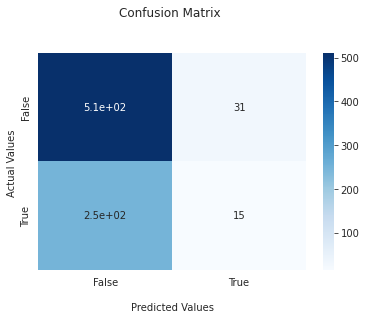

In [25]:
import seaborn as sns

cf = np.array([
    [TN, FP],
    [FN, TP]
])
ax = sns.heatmap(cf, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [26]:
for query in train_df.question2[:2].to_numpy():
  search(query)

#Pinecone

In [27]:
!pip install -qU pip pinecone-client

     |████████████████████████████████| 2.0 MB 29.5 MB/s 
     |████████████████████████████████| 175 kB 74.7 MB/s 
     |████████████████████████████████| 269 kB 62.0 MB/s 
     |████████████████████████████████| 58 kB 7.2 MB/s 


In [28]:
import pinecone
import os

api_key = 'f158288a-05ab-4c9f-8674-4a23758efffe'
pinecone.init(api_key=api_key, environment='us-west1-gcp')

In [29]:
import pinecone.info

version_info = pinecone.info.version()
server_version = ".".join(version_info.server.split(".")[:2])
client_version = ".".join(version_info.client.split(".")[:2])

assert client_version == server_version, "Please upgrade pinecone-client."

In [85]:
# Giving our index a name
index_name = "stem-away"
# Delete the index, if an index of the same name already exists
if index_name in pinecone.list_indexes():
    pinecone.delete_index(index_name)

In [86]:
dimensions = 768     #384
pinecone.create_index(name=index_name, dimension=dimensions) # , metric="cosine", shards=1

In [87]:
index = pinecone.Index(index_name=index_name)

In [88]:
x_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
201990,201990,304141,304142,What is it like working with Elijah Wood?,What is it like to work with Elijah Wood?,0
360317,360317,490095,490096,What is something that amazes you?,What are the 10 most amazing things animals ca...,0
323329,323329,10538,313763,What type of food should I eat to lose weight?,What should I eat while losing weight?,1
362380,362380,492286,492287,How much cloud space is allocated for a Blogsp...,How much can I earn from Adsense on a Blogspot...,0
92311,92311,154551,154552,I wanted to do bcom .i have taken physical edu...,I have taken general maths in SSC and I want t...,0


In [89]:
len(x_train)

808

In [90]:
corpus_embeddings.shape

torch.Size([808, 768])

In [91]:
temp = pd.DataFrame(corpus_embeddings.cpu().numpy())
temp.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.016432,0.048079,0.004299,-0.007714,-0.055263,-0.013608,-0.000460,-0.003564,-0.087666,-0.011283,...,0.077434,-0.009842,0.032447,0.029690,-0.033616,-0.009584,0.000170,-0.009586,-0.003535,-0.020608
1,-0.031851,0.046290,0.003508,-0.009720,-0.008587,0.047651,-0.011566,0.005725,-0.029335,-0.021595,...,-0.038873,0.010243,-0.036804,-0.017136,-0.030448,0.016806,-0.044465,-0.003228,0.032248,0.014075
2,0.070707,0.054599,0.001091,0.024547,0.041110,-0.043171,-0.020536,0.104975,-0.004052,0.038406,...,-0.019346,-0.044213,0.012614,-0.010530,-0.011732,0.021014,0.030571,-0.000716,-0.021036,-0.011998
3,0.073935,0.002710,0.003866,-0.034214,0.002887,0.011064,0.036657,-0.038910,0.018130,0.029263,...,-0.009203,0.011848,0.018952,-0.029829,0.028176,0.028641,0.010704,-0.051273,-0.057796,-0.002663
4,-0.083548,-0.025437,-0.023880,0.020050,0.056444,0.024677,0.037706,-0.042586,0.063047,-0.055579,...,0.033856,0.017850,0.020594,-0.023683,-0.032689,-0.042257,-0.012700,-0.003574,-0.039342,0.014517


In [92]:
vectors_df = pd.DataFrame()
vectors_df['id'] = x_train['id'].apply(lambda x : str(x))
vectors_df['vector']= temp.values.tolist()
vectors_df.head()

,id,vector
201990,201990,"[0.016432076692581177, 0.04807863384485245, 0...."
360317,360317,"[-0.03185119107365608, 0.04629010334610939, 0...."
323329,323329,"[0.0707065537571907, 0.05459878221154213, 0.00..."
362380,362380,"[0.07393541932106018, 0.0027096832636743784, 0..."
92311,92311,"[-0.08354771882295609, -0.02543732523918152, -..."


In [93]:
import itertools

def chunks(iterable, batch_size=100):
    it = iter(iterable)
    chunk = tuple(itertools.islice(it, batch_size))
    while chunk:
        yield chunk
        chunk = tuple(itertools.islice(it, batch_size))

In [94]:
for batch in chunks(zip(vectors_df.id, vectors_df.vector)):
    index.upsert(vectors=batch)

In [51]:
query_embeddings = bi_encoder.encode(x_train.question2[:10].to_numpy(), convert_to_tensor=True, show_progress_bar=True)
query_embeddings.shape

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([10, 768])

In [95]:
%%time
query_embeddings = bi_encoder.encode(x_train.question2.to_numpy(), convert_to_tensor=True, show_progress_bar=True)
query_results = [index.query(xq, top_k=5) for xq in query_embeddings.tolist()]

Batches:   0%|          | 0/26 [00:00<?, ?it/s]

CPU times: user 3.22 s, sys: 172 ms, total: 3.39 s
Wall time: 51.3 s


In [52]:
# query pinecone
query_results = [index.query(xq, top_k=5) for xq in query_embeddings.tolist()]

# show the results
for question, res in zip(x_train.question2[:10].to_numpy(), query_results):
    print("\n\n\n Original question : " + str(question))
    print("\n Most similar questions based on pinecone vector search: \n")

    ids = [match.id for match in res.matches]
    scores = [match.score for match in res.matches]
    df_result = pd.DataFrame(
        {
            "id": ids,
            "question": [
                x_train[x_train.id == int(_id)].question1.values[0] for _id in ids 
            ],
            "score": scores,
        }
    )
    print(df_result)




 Original question : What is it like to work with Elijah Wood?

 Most similar questions based on pinecone vector search: 

       id                                           question     score
0  201990          What is it like working with Elijah Wood?  0.989281
1  100796  How did Frank Abagnale jr. react to the movie ...  0.372496
2  390322   How much does an actor in a commercial get paid?  0.366715
3  246780  Do employees at H&E Equipment Services have a ...  0.303918
4  317226  How does it feel to drive a Lamborghini Aventa...  0.297602



 Original question : What are the 10 most amazing things animals can do?

 Most similar questions based on pinecone vector search: 

       id                                           question     score
0  233274  What are some cute-looking but fierce wild ani...  0.512169
1   79403  What are the characteristics that are common t...  0.440296
2  360317                 What is something that amazes you?  0.401811
3  117508  What are 5 exampl

In [53]:
pinecone.delete_index(index_name)

# Pinecone Hybrid Search

In [ ]:
!pip install -qU pip pinecone-client

In [ ]:
!pip install sentence-transformers sacremoses

In [ ]:
import pinecone
import os

api_key = 'f158288a-05ab-4c9f-8674-4a23758efffe'
pinecone.init(api_key=api_key, environment='us-west1-gcp')

In [ ]:
import pinecone.info

version_info = pinecone.info.version()
server_version = ".".join(version_info.server.split(".")[:2])
client_version = ".".join(version_info.client.split(".")[:2])

assert client_version == server_version, "Please upgrade pinecone-client."

In [ ]:
# Giving our index a name
index_name = "stem-away"
# Delete the index, if an index of the same name already exists
if index_name in pinecone.list_indexes():
    pinecone.delete_index(index_name)

In [ ]:
dimensions = 384
pinecone.create_index(name=index_name, dimension=dimensions) # , metric="cosine", shards=1

In [ ]:
index = pinecone.Index(index_name=index_name)

In [ ]:
questions_data = pd.read_csv('/content/Questions.csv')
questions_data.head(10)

In [ ]:
questions_embeddings = bi_encoder.encode(questions_data.title.to_numpy(), convert_to_tensor=True, show_progress_bar=True)

In [ ]:
vectors_df = pd.DataFrame()
vectors_df['id'] = questions_data['id'].apply(lambda x : str(x))
vectors_df['vector']= pd.DataFrame(questions_embeddings.cpu().numpy()).values.tolist()
vectors_df.head()

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tags_list = [tokenizer.tokenize(sentence.lower()) for sentence in questions_data.tags.to_numpy()]
tags_list[1]

In [ ]:
cleaned_tags = []
specials = ['|', '-', '_', '#','.']
for sentence in tags_list:
  res = [i for i in sentence if i not in specials]
  cleaned_tags.append(res)

cleaned_tags[6]

In [ ]:
import itertools

def chunks(iterable, batch_size=100):
    it = iter(iterable)
    chunk = tuple(itertools.islice(it, batch_size))
    while chunk:
        yield chunk
        chunk = tuple(itertools.islice(it, batch_size))

In [ ]:
upserts = []
for (id, embedding, tokens) in zip(vectors_df.id, vectors_df.vector, cleaned_tags):
    upserts.append((str(id), embedding, {'tokens': tokens}))

In [ ]:
for batch in chunks(upserts):
    index.upsert(vectors=batch)

In [ ]:
query_sentence = "How to print in python?"
xq = bi_encoder.encode(query_sentence).tolist()

In [ ]:
result = index.query(xq, top_k=10, includeMetadata=True)
result

In [ ]:
filters = ['python']
result = index.query(xq, top_k=10, filter={
    'tokens': {'$in': filters}})

ids = [int(x['id']) for x in result['matches']]
for i in ids:
    print(questions_data[questions_data.id == int(i)].title.values[0])

Old result from body embeddings 👇



In [ ]:
filters = ['python']
result = index.query(xq, top_k=10, filter={
    'tokens': {'$in': filters}})

ids = [int(x['id']) for x in result['matches']]
for i in ids:
    print(questions_data[questions_data.id == int(i)].title.values[0])

In [ ]:
pinecone.delete_index(index_name)

# Training

In [54]:
questions_df = pd.read_csv('/content/Questions.csv')
quesitons_clean = questions_df[questions_df['accepted_answer_id'].notna()]
quesitons_clean['accepted_answer_id'] = quesitons_clean['accepted_answer_id'].apply(lambda x: int(round(x)))
quesitons_clean.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,parent_id,post_type_id,score,tags,view_count
2,390605,While vs. Do While,<p>I've seen both the blocks of code in use se...,390608,0,0,NaN,2008-12-24 01:49:54.230000+00:00,2.0,2008-12-24 03:08:55.897000+00:00,NaN,NaN,NaN,Unkwntech,115.0,NaN,1,0,language-agnostic|loops,11086
4,454921,"Difference between ""int[] myArray"" and ""int my...",<blockquote>\n <p><strong>Possible Duplicate:...,454928,0,0,NaN,2009-01-18 10:22:52.177000+00:00,0.0,2009-01-18 10:30:50.930000+00:00,2017-05-23 11:49:26.567000+00:00,NaN,-1.0,Evan Fosmark,49701.0,NaN,1,0,java|arrays,795
6,587584,What is the preferred way to declare a Java ar...,<blockquote>\n <p><strong>Possible Duplicate:...,587594,0,0,NaN,2009-02-25 19:57:22.633000+00:00,0.0,2009-02-25 23:37:23.213000+00:00,2017-05-23 12:20:37.303000+00:00,Eddie,-1.0,Simon,24039.0,NaN,1,0,java|arrays|declaration,626
9,651291,Securing a .NET Application,<h3>Duplicate:</h3>\n<blockquote>\n<p><a href=...,651375,0,0,NaN,2009-03-16 17:07:23.660000+00:00,1.0,2010-06-09 16:17:12.787000+00:00,2020-06-20 09:12:55.060000+00:00,Rich B,-1.0,beakersoft,19638.0,NaN,1,0,.net|security|obfuscation|reverse-engineering,5968
662,8066,.NET Interfaces,<p>Over the past few years I've changed from h...,8086,1,0,NaN,2008-08-11 18:30:44.893000+00:00,NaN,2013-04-04 15:51:01.583000+00:00,2013-04-04 15:51:01.583000+00:00,NaN,1612146.0,NaN,721.0,NaN,1,0,.net|user-controls|interface,811


In [55]:
no_dupes = quesitons_clean[['id','accepted_answer_id','body']]
no_dupes.head()

,id,accepted_answer_id,body
2,390605,390608,<p>I've seen both the blocks of code in use se...
4,454921,454928,<blockquote>\n <p><strong>Possible Duplicate:...
6,587584,587594,<blockquote>\n <p><strong>Possible Duplicate:...
9,651291,651375,<h3>Duplicate:</h3>\n<blockquote>\n<p><a href=...
662,8066,8086,<p>Over the past few years I've changed from h...


In [56]:
answers_df = pd.read_csv('/content/Answers.csv')
answers_clean = answers_df[answers_df['id'].notna()]
answers_clean.head()

,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,parent_id,post_type_id,score,tags,view_count
0,18,NaN,<p>For a table like this:</p>\n\n<pre><code>CR...,NaN,NaN,2,NaN,2008-08-01 05:12:44.193000+00:00,NaN,2016-06-02 05:56:26.060000+00:00,2016-06-02 05:56:26.060000+00:00,Jeff Atwood,126039,phpguy,NaN,17,2,59,NaN,NaN
1,165,NaN,"<p>You can use a <a href=""http://sharpdevelop....",NaN,NaN,0,NaN,2008-08-01 18:04:25.023000+00:00,NaN,2019-04-06 14:03:51.080000+00:00,2019-04-06 14:03:51.080000+00:00,NaN,1721793,user2189331,NaN,145,2,10,NaN,NaN
2,1028,NaN,<p>The VB code looks something like this:</p>\...,NaN,NaN,0,NaN,2008-08-04 04:58:40.300000+00:00,NaN,2013-02-07 13:22:14.680000+00:00,2013-02-07 13:22:14.680000+00:00,NaN,395659,user2189331,NaN,947,2,8,NaN,NaN
3,1073,NaN,<p>My first choice would be a dedicated heap t...,NaN,NaN,0,NaN,2008-08-04 07:51:02.997000+00:00,NaN,2015-09-01 17:32:32.120000+00:00,2015-09-01 17:32:32.120000+00:00,NaN,45459,user2189331,NaN,1069,2,29,NaN,NaN
4,1260,NaN,<p>I found the answer. all you have to do is a...,NaN,NaN,0,NaN,2008-08-04 14:06:02.863000+00:00,NaN,2016-12-20 08:38:48.867000+00:00,2016-12-20 08:38:48.867000+00:00,NaN,1221571,Jin,NaN,1229,2,1,NaN,NaN


In [57]:
questions_df.head()

,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,parent_id,post_type_id,score,tags,view_count
0,320268,Html.ActionLink doesn’t render # properly,<p>When using Html.ActionLink passing a string...,NaN,0,0,NaN,2008-11-26 10:42:37.477000+00:00,0.0,2009-02-06 20:13:54.370000+00:00,NaN,NaN,NaN,Paulo,NaN,NaN,1,0,asp.net-mvc,380
1,324003,Primitive recursion,<p>how will i define the function 'simplify' ...,NaN,0,0,NaN,2008-11-27 15:12:37.497000+00:00,0.0,2012-09-25 19:54:40.597000+00:00,2012-09-25 19:54:40.597000+00:00,Marcin,1288.0,NaN,41000.0,NaN,1,0,haskell|lambda|functional-programming|lambda-c...,488
2,390605,While vs. Do While,<p>I've seen both the blocks of code in use se...,390608.0,0,0,NaN,2008-12-24 01:49:54.230000+00:00,2.0,2008-12-24 03:08:55.897000+00:00,NaN,NaN,NaN,Unkwntech,115.0,NaN,1,0,language-agnostic|loops,11086
3,413246,Protect ASP.NET Source code,<p>Im currently doing some research in how to ...,NaN,0,0,NaN,2009-01-05 14:23:51.040000+00:00,0.0,2009-03-24 21:30:22.370000+00:00,2009-01-05 14:42:28.257000+00:00,Tom Anderson,13502.0,Velnias,NaN,NaN,1,0,asp.net|deployment|obfuscation,4811
4,454921,"Difference between ""int[] myArray"" and ""int my...",<blockquote>\n <p><strong>Possible Duplicate:...,454928.0,0,0,NaN,2009-01-18 10:22:52.177000+00:00,0.0,2009-01-18 10:30:50.930000+00:00,2017-05-23 11:49:26.567000+00:00,NaN,-1.0,Evan Fosmark,49701.0,NaN,1,0,java|arrays,795


In [58]:
ans = pd.DataFrame()
ans['accepted_answer_id'] = answers_clean['id']
ans['accepted_answer_id'] = ans['accepted_answer_id'].apply(lambda x: int(round(x)))
ans['body_2'] = answers_clean['body']

In [59]:
# answers_df.loc[answers_df['accepted_answer_id'] == 454928]
merged_df = no_dupes.merge(ans, on='accepted_answer_id', how='inner')
merged_df['label'] = 1
merged_df.head()

,id,accepted_answer_id,body,body_2,label
0,20899,25178,"<p>Two RAID volumes, VMware kernel/console run...",<p>It was the backplane. Both drives of the RA...,1
1,27889,28346,<p>I am trying to get SpecUnit to run in a con...,<p>You need to specify the full path to the as...,1
2,56859,58647,<p>In SCSF application I would like to display...,"<p>Assuming you're talking about Winforms, not...",1
3,62027,68148,"<p>I had to use a <a href=""http://msdn.microso...","<p>Does <a href=""http://geeknotes.wordpress.co...",1
4,68898,68914,<p>Does there exist a website service or set o...,"<p>I believe the <a href=""http://validator.w3....",1


In [60]:
merged_df.describe()

,id,accepted_answer_id,label
count,51.000000,51.000000,51.0
mean,400853.666667,406525.137255,1.0
std,192853.202959,191203.212923,0.0
min,20899.000000,25178.000000,1.0
25%,246996.500000,254659.000000,1.0
50%,434680.000000,446496.000000,1.0
75%,590776.000000,591229.500000,1.0
max,658484.000000,658507.000000,1.0


In [61]:
# nan_df_q = questions_df[questions_df['accepted_answer_id'].isna()]
# nan_df_a =  answers_df[answers_df['accepted_answer_id'].isna()]
# nan_questions = nan_df_q[['id','accepted_answer_id','body']]
# nan_answers = pd.DataFrame()
# nan_answers['accepted_answer_id'] = nan_df_a['id']
# nan_answers['accepted_answer_id'] = nan_answers['accepted_answer_id'].apply(lambda x: int(round(x)))
# nan_answers['body_2'] = nan_df_a['body']
# merged_nan = nan_questions.merge(nan_answers, on='accepted_answer_id', how='inner')
# merged_nan['label'] = 0
# merged_nan.head()

merged_df_2 = pd.DataFrame()
merged_df_2['id'] = answers_df[:52]['id']
merged_df_2['accepted_answer_id'] = answers_clean[100:152]['id'].to_numpy()
merged_df_2['body'] = answers_df[:52]['body']
merged_df_2['body_2'] = answers_clean[100:152]['body'].to_numpy()
merged_df_2['label'] = 0
merged_df_2.head()


,id,accepted_answer_id,body,body_2,label
0,18,64635,<p>For a table like this:</p>\n\n<pre><code>CR...,<p>If you are referring to using a custom imag...,0
1,165,64795,"<p>You can use a <a href=""http://sharpdevelop....",<pre><code>cout &lt;&lt; text &lt;&lt; i;\n</c...,0
2,1028,64807,<p>The VB code looks something like this:</p>\...,<p>Regular expressions are overkill for this s...,0
3,1073,64834,<p>My first choice would be a dedicated heap t...,<p>Try <kbd>Ctrl-x</kbd> followed by <kbd>Ctrl...,0
4,1260,64845,<p>I found the answer. all you have to do is a...,"<p>Also, if you want to get rid of the list of...",0


In [62]:
new_train_data = pd.concat([merged_df,merged_df_2])
# shuffle the data
indices = np.arange(len(new_train_data))
np.random.shuffle(indices)
new_train_data = new_train_data.iloc[indices]
new_train_data.head()

,id,accepted_answer_id,body,body_2,label
46,33930,74285,"<p>In <strong>traditional recursion</strong>, ...",<p>Do you want to insert extraction in an exis...,0
17,11775,66337,"<p>The <a href=""http://msdn.microsoft.com/en-u...",<p>The secret is to surround your whole thingi...,0
39,594451,594456,<p>I have some UI bound to an ObservableCollec...,<p>As long as the property exposing the collec...,1
32,23335,71295,<p>I believe that procedural/functional/object...,<p>You should also consider the <code>array</c...,0
41,33035,73250,<p>They are very similar. With Objective-C 2.0...,<p>I use D for a hardware in the loop (HIL) te...,0


In [72]:
from torch.utils.data import DataLoader
import math
from sentence_transformers import LoggingHandler, util
from sentence_transformers.cross_encoder import CrossEncoder
from sentence_transformers.cross_encoder.evaluation import CEBinaryClassificationEvaluator
from sentence_transformers.readers import InputExample
import logging
from datetime import datetime
import os
import gzip
import csv
from zipfile import ZipFile


def train(model, train_data, val_data, num_epochs=5, batch=16):
     #### Just some code to print debug information to stdout
    logging.basicConfig(format='%(asctime)s - %(message)s',
                        datefmt='%Y-%m-%d %H:%M:%S',
                        level=logging.INFO,
                        handlers=[LoggingHandler()])
    logger = logging.getLogger(__name__)
    
    #Reading our new data
    train_samples = []
    for idx, row in train_data.iterrows():
            train_samples.append(InputExample(texts=[row['body'], row['body_2']], label=int(row['label'])))
            train_samples.append(InputExample(texts=[row['body_2'], row['body']], label=int(row['label'])))
            


    dev_samples = []
    for idx, row in val_data.iterrows():
            dev_samples.append(InputExample(texts=[row['body'], row['body_2']], label=int(row['label'])))

    #Configuration
    model_save_path = 'output/training_Custome_dataset-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

      
    # We wrap train_samples (which is a List[InputExample]) into a pytorch DataLoader
    train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=batch)


    # We add an evaluator, which evaluates the performance during training
    evaluator = CEBinaryClassificationEvaluator.from_input_examples(dev_samples, name='Quora-dev')


    # Configure the training
    warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
    logger.info("Warmup-steps: {}".format(warmup_steps))


    # Train the model
    model.fit(train_dataloader=train_dataloader,
              evaluator=evaluator,
              epochs=num_epochs,
              evaluation_steps=100,
              warmup_steps=warmup_steps,
              output_path=model_save_path)
    
    return model

In [73]:
# We use distilroberta-base with a single label, i.e., it will output a value between 0 and 1 indicating the similarity of the two questions
model = CrossEncoder('distilroberta-base', num_labels=1)
model = train(model, new_train_data, new_train_data,)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.bias

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

In [67]:
def search_2(query, cross_encoder, top=3):
   
    ##### Sematic Search #####
    # Encode the query using the bi-encoder and find potentially relevant passages
    question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
    question_embedding = question_embedding.cuda()
    hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=top_k)
    hits = hits[0]  # Get the hits for the first query

    ##### Re-Ranking #####
    # Now, score all retrieved passages with the cross_encoder
    cross_inp = [[query, passages[hit['corpus_id']]] for hit in hits]
    cross_scores = cross_encoder.predict(cross_inp)

    # Sort results by the cross-encoder scores
    for idx in range(len(cross_scores)):
        hits[idx]['cross-score'] = cross_scores[idx]

    # Output of top-k hits from bi-encoder
    
    bi_encoder_hits = sorted(hits, key=lambda x: x['score'], reverse=True)
    
    bi_list, scores = [],[]
    for hit in bi_encoder_hits[0:top]:
        bi_list.append(passages[hit['corpus_id']])
        scores.append(hit['score'])

    # Output of top-k hits from re-ranker
   
    cross_encoder_hits = sorted(bi_encoder_hits, key=lambda x: x['cross-score'], reverse=True)
    cross_list, scores_cross = [], []
    for hit in cross_encoder_hits[0:3]:
        cross_list.append((passages[hit['corpus_id']]))
        scores_cross.append(hit['cross-score'])
    return bi_list, cross_list, scores, scores_cross

In [68]:
from collections import defaultdict
def compute_hits_2(embeddings, questions_list, cross_encoder, model = 'cross', top=3):
  hits_dict = defaultdict(lambda: 0.0)
  for idx, question in enumerate(questions_list):
    hits = []
    bi_hits, cross_hit, bi_scores, cross_scores = search_2(question, cross_encoder= cross_encoder, top=top)
    if model == 'bi':
      hits_dict[idx] = (bi_hits, bi_scores)
    else:
      hits_dict[idx] = (cross_hit, cross_scores)
  return hits_dict

In [69]:
hits = compute_hits_2(corpus_embeddings, x_train.question2.to_numpy(),cross_encoder=model,top=5)

In [70]:
accuracy, sensitivity, specificity, FPR , TP, TN, FP, FN= evaluate(hits, x_train.question1.to_numpy(),x_train.is_duplicate.to_numpy())

In [71]:
accuracy, sensitivity, specificity, FPR, TP,TN,FP,FN

(62.12871287128713,
 0.09398496240601503,
 0.8800738007380073,
 0.11992619926199266,
 25,
 477,
 65,
 241)

# Scrapped Data Merge

In [13]:
import pandas as pd
forum_1 = pd.read_csv('/content/forum_data_full_1.csv')
forum_2 = pd.read_csv('/content/forum_data_full_2.csv')
forum_3 = pd.read_csv('/content/forum_data_full_3.csv')
forum_4 = pd.read_csv('/content/forum_data_full_4.csv')
forum_5 = pd.read_csv('/content/forum_data_full_5.csv')
forum_6 = pd.read_csv('/content/forum_data_full_6.csv')

In [14]:
combined_forum = pd.concat([forum_1, forum_2, forum_3, forum_4, forum_5, forum_6], ignore_index=True)
combined_forum.describe()

,Replies,Users,Likes,Links
count,14023.000000,14023.000000,14023.000000,14023.000000
mean,7.638095,4.088711,1.655780,0.840619
std,57.193322,17.600942,9.132987,2.877556
min,0.000000,1.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000
50%,2.000000,2.000000,0.000000,0.000000
75%,4.000000,3.000000,1.000000,1.000000
max,3151.000000,1052.000000,377.000000,50.000000


In [15]:
combined_forum.Category.value_counts()

Audio                                     984
Pipeline And Plugins                      980
Community And Industry                    978
Platform And Builds                       971
AnswerHub                                 667
Marketplace                               658
Cinematics And Media                      547
Character And Animation                   546
UDK Programming and UnrealScript          544
Rendering                                 544
Asset Creation                            542
Programming And Scripting                 540
World Creation                            539
Got Skills Looking For Talent             536
Tutorial And Course Discussion            536
Getting Started                           534
ARK Survival Evolved                      531
Showcase                                  528
Off Topic                                 527
Feedback For The Unreal Engine Team       483
Announcements                             476
Architectural And Design Visualiza

In [16]:
combined_forum.to_csv('merged_forum.csv',index=False)

# TF-IDF Filtering

In [51]:
df = pd.read_csv('/content/Questions.csv')
df.head()

,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,parent_id,post_type_id,score,tags,view_count
0,320268,Html.ActionLink doesn’t render # properly,<p>When using Html.ActionLink passing a string...,NaN,0,0,NaN,2008-11-26 10:42:37.477000+00:00,0.0,2009-02-06 20:13:54.370000+00:00,NaN,NaN,NaN,Paulo,NaN,NaN,1,0,asp.net-mvc,380
1,324003,Primitive recursion,<p>how will i define the function 'simplify' ...,NaN,0,0,NaN,2008-11-27 15:12:37.497000+00:00,0.0,2012-09-25 19:54:40.597000+00:00,2012-09-25 19:54:40.597000+00:00,Marcin,1288.0,NaN,41000.0,NaN,1,0,haskell|lambda|functional-programming|lambda-c...,488
2,390605,While vs. Do While,<p>I've seen both the blocks of code in use se...,390608.0,0,0,NaN,2008-12-24 01:49:54.230000+00:00,2.0,2008-12-24 03:08:55.897000+00:00,NaN,NaN,NaN,Unkwntech,115.0,NaN,1,0,language-agnostic|loops,11086
3,413246,Protect ASP.NET Source code,<p>Im currently doing some research in how to ...,NaN,0,0,NaN,2009-01-05 14:23:51.040000+00:00,0.0,2009-03-24 21:30:22.370000+00:00,2009-01-05 14:42:28.257000+00:00,Tom Anderson,13502.0,Velnias,NaN,NaN,1,0,asp.net|deployment|obfuscation,4811
4,454921,"Difference between ""int[] myArray"" and ""int my...",<blockquote>\n <p><strong>Possible Duplicate:...,454928.0,0,0,NaN,2009-01-18 10:22:52.177000+00:00,0.0,2009-01-18 10:30:50.930000+00:00,2017-05-23 11:49:26.567000+00:00,NaN,-1.0,Evan Fosmark,49701.0,NaN,1,0,java|arrays,795


In [34]:
len(df)

10000

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
tf = vectorizer.fit_transform(['My short sentence for exploration', 'My shorter sentence for exploration'])
((tf * tf.T).A)

array([[1.        , 0.66941885],
       [0.66941885, 1.        ]])

In [35]:
SPECIAL_TOKENS = {
    'quoted': 'quoted_item',
    'non-ascii': 'non_ascii_word',
    'undefined': 'something'
}

def clean(text, stem_words=True):
    import re
    from string import punctuation
    from nltk.stem import SnowballStemmer
    from nltk.corpus import stopwords
    
    def pad_str(s):
        return ' '+s+' '
    
    if pd.isnull(text):
        return ''

    if type(text) != str or text=='':
        return ''

    # Clean the text
    text = re.sub("\'s", " ", text) # we have cases like "Sam is" or "Sam's" (i.e. his) these two cases aren't separable, I choose to compromise are kill "'s" directly
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("can't", "can not", text)
    text = re.sub("n't", " not ", text)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    text = re.sub("b\.g\.", " bg ", text, flags=re.IGNORECASE)
    text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?United State(s)?", " America ", text, flags=re.IGNORECASE)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)
    
    # remove comma between numbers, i.e. 15,000 -> 15000
    
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)
    text = re.sub('[^\x00-\x7F]+', pad_str(SPECIAL_TOKENS['non-ascii']), text) # replace non-ascii word with special word
    
    # indian dollar
    
    text = re.sub("(?<=[0-9])rs ", " rs ", text, flags=re.IGNORECASE)
    text = re.sub(" rs(?=[0-9])", " rs ", text, flags=re.IGNORECASE)
    
    # clean text rules get from : https://www.kaggle.com/currie32/the-importance-of-cleaning-text
    text = re.sub(r" (the[\s]+|The[\s]+)?US(A)? ", " America ", text)
    text = re.sub(r" UK ", " England ", text, flags=re.IGNORECASE)
    text = re.sub(r" india ", " India ", text)
    text = re.sub(r" switzerland ", " Switzerland ", text)
    text = re.sub(r" china ", " China ", text)
    text = re.sub(r" chinese ", " Chinese ", text) 
    text = re.sub(r" imrovement ", " improvement ", text, flags=re.IGNORECASE)
    text = re.sub(r" intially ", " initially ", text, flags=re.IGNORECASE)
    text = re.sub(r" quora ", " Quora ", text, flags=re.IGNORECASE)
    text = re.sub(r" dms ", " direct messages ", text, flags=re.IGNORECASE)  
    text = re.sub(r" demonitization ", " demonetization ", text, flags=re.IGNORECASE) 
    text = re.sub(r" actived ", " active ", text, flags=re.IGNORECASE)
    text = re.sub(r" kms ", " kilometers ", text, flags=re.IGNORECASE)
    text = re.sub(r" cs ", " computer science ", text, flags=re.IGNORECASE) 
    text = re.sub(r" upvote", " up vote", text, flags=re.IGNORECASE)
    text = re.sub(r" iPhone ", " phone ", text, flags=re.IGNORECASE)
    text = re.sub(r" \0rs ", " rs ", text, flags=re.IGNORECASE)
    text = re.sub(r" calender ", " calendar ", text, flags=re.IGNORECASE)
    text = re.sub(r" ios ", " operating system ", text, flags=re.IGNORECASE)
    text = re.sub(r" gps ", " GPS ", text, flags=re.IGNORECASE)
    text = re.sub(r" gst ", " GST ", text, flags=re.IGNORECASE)
    text = re.sub(r" programing ", " programming ", text, flags=re.IGNORECASE)
    text = re.sub(r" bestfriend ", " best friend ", text, flags=re.IGNORECASE)
    text = re.sub(r" dna ", " DNA ", text, flags=re.IGNORECASE)
    text = re.sub(r" III ", " 3 ", text)
    text = re.sub(r" banglore ", " Banglore ", text, flags=re.IGNORECASE)
    text = re.sub(r" J K ", " JK ", text, flags=re.IGNORECASE)
    text = re.sub(r" J\.K\. ", " JK ", text, flags=re.IGNORECASE)
    
    # replace the float numbers with a random number, it will be parsed as number afterward, and also been replaced with word "number"
    
    text = re.sub('[0-9]+\.[0-9]+', " 87 ", text)
  
    
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation]).lower()
       # Return a list of words
    return text
    
df['title'] = df['title'].apply(clean)
# df['question2'] = df['question2'].apply(clean)


In [52]:
#import the nltk package
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

def split_sent(row):
  return row.split()


def stemming(row):
  stemmer = PorterStemmer()
  new_row = []
  for elem in row:
    new_row.append(stemmer.stem(elem))
  return new_row


def lemmatizing(row):
  lemmatizer = WordNetLemmatizer()
  new_row = []
  for elem in row:
    new_row.append(lemmatizer.lemmatize(elem))
  return new_row


def join_sent(row):
  return " ".join(row)


df['title'] = df['title'].apply(split_sent)
df['title'] = df['title'].apply(stemming)
# df['title'] = df['title'].apply(lemmatizing)
# df['title'] = df['title'].apply(join_sent)
df.head()

,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,parent_id,post_type_id,score,tags,view_count
0,320268,"[html.actionlink, doesn’t, render, #, properli]",<p>When using Html.ActionLink passing a string...,NaN,0,0,NaN,2008-11-26 10:42:37.477000+00:00,0.0,2009-02-06 20:13:54.370000+00:00,NaN,NaN,NaN,Paulo,NaN,NaN,1,0,asp.net-mvc,380
1,324003,"[primit, recurs]",<p>how will i define the function 'simplify' ...,NaN,0,0,NaN,2008-11-27 15:12:37.497000+00:00,0.0,2012-09-25 19:54:40.597000+00:00,2012-09-25 19:54:40.597000+00:00,Marcin,1288.0,NaN,41000.0,NaN,1,0,haskell|lambda|functional-programming|lambda-c...,488
2,390605,"[while, vs., do, while]",<p>I've seen both the blocks of code in use se...,390608.0,0,0,NaN,2008-12-24 01:49:54.230000+00:00,2.0,2008-12-24 03:08:55.897000+00:00,NaN,NaN,NaN,Unkwntech,115.0,NaN,1,0,language-agnostic|loops,11086
3,413246,"[protect, asp.net, sourc, code]",<p>Im currently doing some research in how to ...,NaN,0,0,NaN,2009-01-05 14:23:51.040000+00:00,0.0,2009-03-24 21:30:22.370000+00:00,2009-01-05 14:42:28.257000+00:00,Tom Anderson,13502.0,Velnias,NaN,NaN,1,0,asp.net|deployment|obfuscation,4811
4,454921,"[differ, between, ""int[], myarray"", and, ""int,...",<blockquote>\n <p><strong>Possible Duplicate:...,454928.0,0,0,NaN,2009-01-18 10:22:52.177000+00:00,0.0,2009-01-18 10:30:50.930000+00:00,2017-05-23 11:49:26.567000+00:00,NaN,-1.0,Evan Fosmark,49701.0,NaN,1,0,java|arrays,795


## Stemming Title

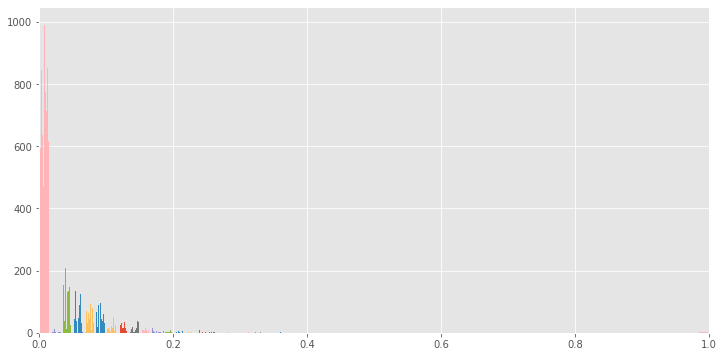

In [37]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


vectorizer = TfidfVectorizer()
def cosine_sim(text1, text2):
    try:
        tfidf = vectorizer.fit_transform([text1, text2])
    except Exception:
        print(text1)
        print("-------------------")
        print(text2)
    
    return ((tfidf * tfidf.T).A)[0,1]

Tfidf_scores = []
score_idx = []
for i in range(1000):
  score_list = [] 
  for j in range(1000):
    try:
        score = cosine_sim(df['title'][i], df['title'][j])
    except Exception:
        print("error---")
        continue
    score_list.append(score)
  temp = np.array(score_list)
  score_list.sort(reverse=True)
  # Tfidf_scores.append(score_list[1:10])
  # score_idx.append(np.argsort(-temp)[1:10])
  Tfidf_scores.append(score_list)
  score_idx.append(np.argsort(-temp))

score = pd.DataFrame(Tfidf_scores)
score.head(10)

# Plot the scores
plt.figure(figsize=(12,6))
plt.style.use('ggplot')
plt.hist(Tfidf_scores, bins = 60)
plt.xlim(0,1)
plt.show()

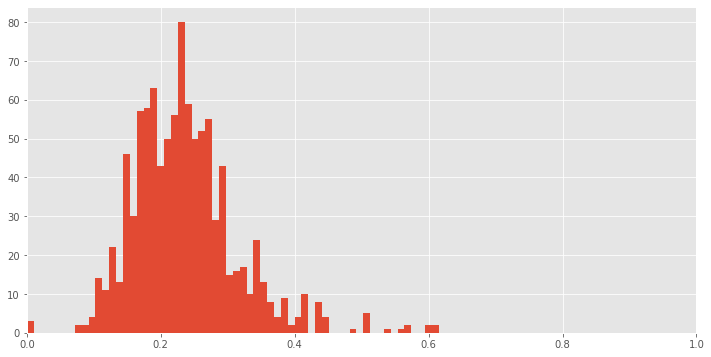

In [ ]:
new_2 = []
for x in Tfidf_scores:
  new_2.append(np.array(x[0]))


score_ = pd.DataFrame(new_2)
score_.head(10)

# Plot the scores
plt.figure(figsize=(12,6))
plt.style.use('ggplot')
plt.hist(new_2, bins = 60)
plt.xlim(0,1)
plt.show()

In [40]:
new_dataset_2 = pd.DataFrame(columns=["id", "question_1", "question_2", 'Q2_score','rogue_one','R_score'])

for idx in range(500):
  # new_row = pd.Series({"id": idx, "question_1": df.clean[idx], "question_2":df.clean[new_3[idx]]})
  new_dataset_2.loc[idx] = [idx,df.title[idx],df.title[score_idx[idx][1]],Tfidf_scores[idx][1], df.title[score_idx[idx][-490]], Tfidf_scores[idx][-490]]

In [41]:
new_dataset_2.head(10)

,id,question_1,question_2,Q2_score,rogue_one,R_score
0,0,htmlactionlink doesn nonasciiword t render pr...,longtail jw player not starting properly,0.101631,problem with sorted map when a value is null,0.000000
1,1,primitive recursion,htmlactionlink doesn nonasciiword t render pr...,0.000000,wmv scaling in firefox 87 3,0.000000
2,2,while vs do while,error occurred while decoding oaep padding,0.215070,how do i create a windows service with python,0.084580
3,3,protect aspnet source code,what is source code control for,0.260556,mixing xaml and code to add controls wpf,0.098680
4,4,difference between int myarray and int myarray...,what the difference between requestsecurityto...,0.230096,loadtesting vs threading in iis 7 and net 8...,0.103202
5,5,looking for wpfxaml example that gets xml from...,linq2xsd looking for articles tutorials and e...,0.175266,patch error 2229 for nondefault languages in w...,0.103202
6,6,what is the preferred way to declare a java array,what is the proper way to setup events for inh...,0.360911,how to get the wtsclientaddress from the javal...,0.183693
7,7,how do i create a windows service with python,how do i selfhost a tcpbased wcf service insid...,0.411122,how can i make my windows form to do and displ...,0.175830
8,8,best c profiler,squid best practices for caching,0.194314,interpolation and templating,0.000000
9,9,securing a net application,clickonce and application settings,0.170776,how to run jar application from window service...,0.109643


In [42]:
new_dataset_2.R_score.describe()

count    500.000000
mean       0.117641
std        0.051748
min        0.000000
25%        0.092698
50%        0.116718
75%        0.144384
max        0.269577
Name: R_score, dtype: float64

## Lemmetization Title


In [63]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [65]:
df = pd.read_csv('/content/Questions.csv')
#import the nltk package
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

def split_sent(row):
  return row.split()


def stemming(row):
  stemmer = PorterStemmer()
  new_row = []
  for elem in row:
    new_row.append(stemmer.stem(elem))
  return new_row


def lemmatizing(row):
  lemmatizer = WordNetLemmatizer()
  new_row = []
  for elem in row:
    new_row.append(lemmatizer.lemmatize(elem))
  return new_row


def join_sent(row):
  return " ".join(row)


df['title'] = df['title'].apply(split_sent)
# df['title'] = df['title'].apply(stemming)
df['title'] = df['title'].apply(lemmatizing)
df['title'] = df['title'].apply(join_sent)

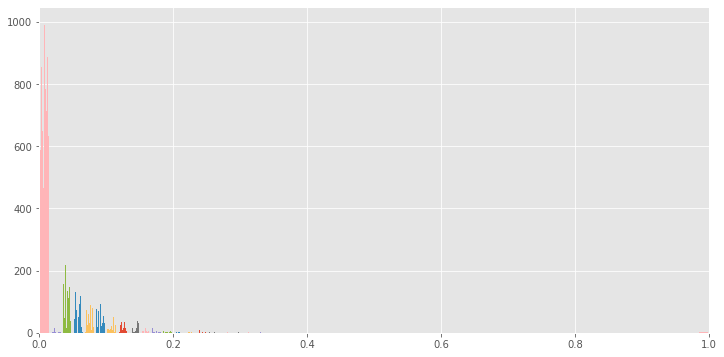

In [67]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


vectorizer = TfidfVectorizer()
def cosine_sim(text1, text2):
    try:
        tfidf = vectorizer.fit_transform([text1, text2])
    except Exception:
        print(text1)
        print("-------------------")
        print(text2)
    
    return ((tfidf * tfidf.T).A)[0,1]

Tfidf_scores_lemmt = []
score_idx_lemmt= []
for i in range(1000):
  score_list = [] 
  for j in range(1000):
    try:
        score = cosine_sim(df['title'][i], df['title'][j])
    except Exception:
        print("error---")
        continue
    score_list.append(score)
  temp = np.array(score_list)
  score_list.sort(reverse=True)
  # Tfidf_scores.append(score_list[1:10])
  # score_idx.append(np.argsort(-temp)[1:10])
  Tfidf_scores_lemmt.append(score_list)
  score_idx_lemmt.append(np.argsort(-temp))

score = pd.DataFrame(Tfidf_scores_lemmt)
score.head(10)

# Plot the scores
plt.figure(figsize=(12,6))
plt.style.use('ggplot')
plt.hist(Tfidf_scores_lemmt, bins = 60)
plt.xlim(0,1)
plt.show()

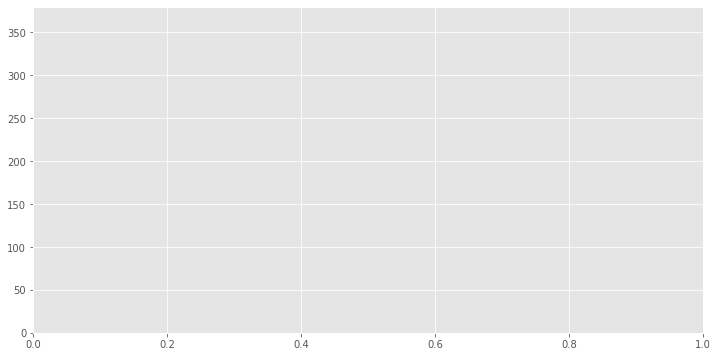

In [68]:
new_lemmtize = []
for x in Tfidf_scores_lemmt:
  new_lemmtize.append(np.array(x[0]))

# Plot the scores
plt.figure(figsize=(12,6))
plt.style.use('ggplot')
plt.hist(new_lemmtize, bins = 60)
plt.xlim(0,1)
plt.show()

In [69]:
new_dataset_lemmtize = pd.DataFrame(columns=["id", "question_1", "question_2", 'Q2_score','rogue_one','R_score'])

for idx in range(500):
  # new_row = pd.Series({"id": idx, "question_1": df.clean[idx], "question_2":df.clean[new_3[idx]]})
  new_dataset_lemmtize.loc[idx] = [idx,df.title[idx],df.title[score_idx_lemmt[idx][1]],Tfidf_scores_lemmt[idx][1], df.title[score_idx_lemmt[idx][-490]], Tfidf_scores_lemmt[idx][-490]]

## Body TF-IDF

In [51]:
import pandas as pd
from bs4 import BeautifulSoup
import re
import html

def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>|&.{4};')
    cleantext = re.sub(cleanr, '', str(raw_html))
#     replacing the special characters
    clean = re.sub('\s+',' ',cleantext)
    return html.unescape(clean) # replaces the special characters


#same using beautifulsoup

def remove_html_escape(html):
    return BeautifulSoup(str(html), "lxml").text

new_df = pd.DataFrame(df)
# column 'clean' contins regex replacement of anything in between < > or &; or \\* \nin otherwords, it removes any html with the space character, no conversion of special characters to respective ASCII values.
new_df['clean'] = new_df['body'].apply(cleanhtml)

# column 'clean_bs' contains html removed with special characters replaced with their respective ASCII characters.
new_df['clean'] = new_df['clean'].apply(remove_html_escape)

new_df.clean.head()

0    When using Html.ActionLink passing a string co...
1    how will i define the function 'simplify' usin...
2    I've seen both the blocks of code in use sever...
3    Im currently doing some research in how to bes...
4    Possible Duplicate: Difference between int[] a...
Name: clean, dtype: object

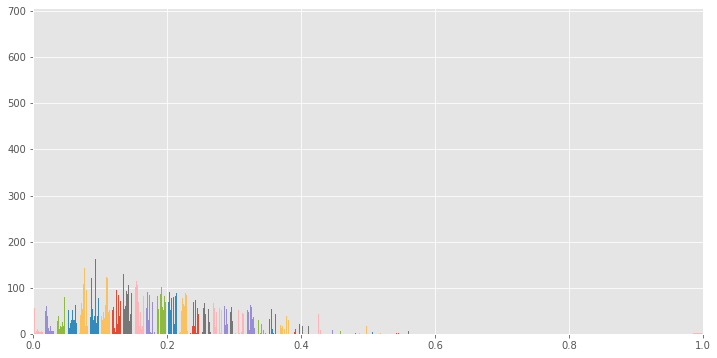

In [52]:
vectorizer_2 = TfidfVectorizer()
def cosine_sim(text1, text2, vector):
    try:
        tfidf = vector.fit_transform([text1, text2])
    except Exception:
        print(text1)
        print("-------------------")
        print(text2)
    
    return ((tfidf * tfidf.T).A)[0,1]

Tfidf_scores_ = []
score_idx_ = []
for i in range(1000):
  score_list = [] 
  for j in range(1000):
    try:
        score = cosine_sim(new_df['clean'][i], new_df['clean'][j], vectorizer_2)
    except Exception:
        print("error---")
        continue
    score_list.append(score)
  
  temp = np.array(score_list)
  score_list.sort(reverse=True)
  # Tfidf_scores_.append(score_list[1:10])
  # score_idx_.append(np.argsort(-temp)[1:10])
  Tfidf_scores_.append(score_list)
  score_idx_.append(np.argsort(-temp))

score = pd.DataFrame(Tfidf_scores_)

# Plot the scores
plt.figure(figsize=(12,6))
plt.style.use('ggplot')
plt.hist(Tfidf_scores_, bins = 60)
plt.xlim(0,1)
plt.show()

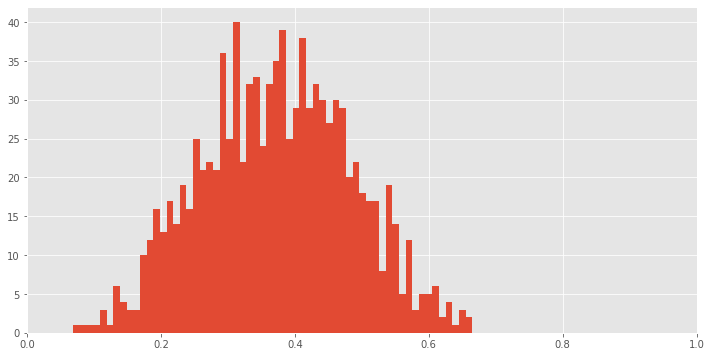

In [ ]:
new_3 = []
for x in Tfidf_scores_:
  new_3.append(np.array(x[0]))

# Plot the scores
plt.figure(figsize=(12,6))
plt.style.use('ggplot')
plt.hist(new_3, bins = 60)
plt.xlim(0,1)
plt.show()

In [53]:
new_dataset_3 = pd.DataFrame(columns=["id", "question_1", "question_2",'Q2_score','rogue_one','R_score'])

for idx in range(1000):
  # new_row = pd.Series({"id": idx, "question_1": df.clean[idx], "question_2":df.clean[new_3[idx]]})
  new_dataset_3.loc[idx] = [idx,new_df.clean[idx],new_df.clean[score_idx_[idx][1]],Tfidf_scores_[idx][1], new_df.clean[score_idx_[idx][-490]], Tfidf_scores_[idx][-490]]

In [50]:
len(a), len(Tfidf_scores), len(score_idx)

(10000, 1537, 1537)

In [ ]:
new_dataset_3.head()

,id,question_1,question_2
0,0,When using Html.ActionLink passing a string co...,A WebDAV library I'm using is issuing this req...
1,1,how will i define the function 'simplify' usin...,Using an idea from Bob King idea I wrote the f...
2,2,I've seen both the blocks of code in use sever...,This is related to an earlier question I asked...
3,3,Im currently doing some research in how to bes...,I'm having some conceptual trouble on figuring...
4,4,Possible Duplicate: Difference between int[] a...,Possible Duplicate: What is the difference bet...


In [ ]:
new_dataset_3.loc[2].question_1, '/n',new_dataset_3.loc[2].question_2

("I've seen both the blocks of code in use several different times, personally I have always used the first but my question is: is there a functional difference, and if there is what is it? while (condition is true ) { // do something } do { // do something } while ( condition is true); I will be applying this to PHP but I assume this is fairly language agnostic.",
 '/n',
 "This is related to an earlier question I asked. The Google Static Maps API certainly seems like the way to go given the technical constraints, however, the business constraints are different and I'm starting to think there is no point where they overlap. In short, I need to generate a map image with ZIP code boundaries, and the ZIP codes shaded in different ways to highlight some and dim others. This is obviously not something that Google has available in their API, so is there something I can do on my end to use their geocoding, their mapping, and mix in the ZIP code imagery? Without somehow building my own nation-

## Sentence transformer encodings

In [54]:
df = pd.read_csv('/content/Questions.csv')
len(df)

10000

In [55]:
from sentence_transformers import SentenceTransformer, CrossEncoder, util
import torch
encoder = SentenceTransformer('all-mpnet-base-v2')
encoder.max_seq_length = 256     #Truncate long passages to 256 tokens

embeddings = encoder.encode(df['title'].to_numpy(), convert_to_tensor=True, show_progress_bar=True)
embeddings.shape

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

torch.Size([10000, 768])

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
tf = vectorizer.fit_transform(['my short sentence', 'my shorter sentence'])
((tf * tf.T).A)[0,1]

0.5031026124151314

In [9]:
tf = vectorizer.fit_transform(['the sentence length actually makes a difference in this',
                               'the sentence length actually makes a difference in this case'])
((tf * tf.T).A)[0,1]

0.8955324150715727

In [10]:
((tf * tf.T).A)

array([[1.        , 0.89553242],
       [0.89553242, 1.        ]])

In [56]:
cos = torch.nn.CosineSimilarity()
Tfidf_scores_2 = []
score_idx_2 = []
for i in range(1000):
  score_list = [] 
  for j in range(1000):
    score = cos(embeddings[i].unsqueeze(0), embeddings[j].unsqueeze(0))
    score_list.append(score.cpu())
  
  temp = np.array(score_list)
  score_list.sort(reverse=True)
  # Tfidf_scores_2.append(score_list[1:10])
  # score_idx_2.append(np.argsort(-temp)[1:10])
  Tfidf_scores_2.append(score_list)
  score_idx_2.append(np.argsort(-temp))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


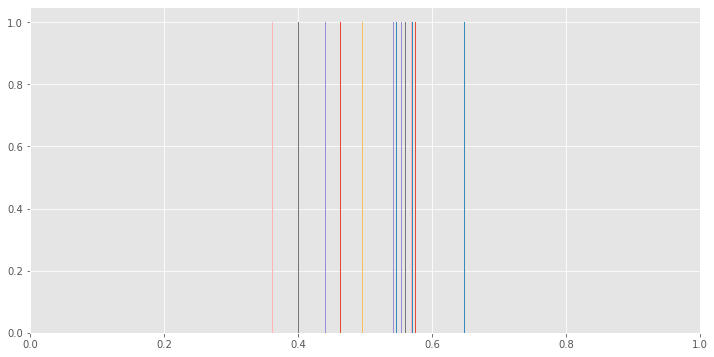

In [31]:
new_4 = []
for x in Tfidf_scores_2:
  new_4.append(np.array(x[0]))

# Plot the scores
plt.figure(figsize=(12,6))
plt.style.use('ggplot')
plt.hist(new_4, bins = 60)
plt.xlim(0,1)
plt.show()

In [57]:
new_dataset_4 = pd.DataFrame(columns=["id", "question_1", "question_2", 'Q2_score','rogue_one','R_score'])

for idx in range(1000):
  # new_row = pd.Series({"id": idx, "question_1": df.clean[idx], "question_2":df.clean[new_3[idx]]})
  new_dataset_4.loc[idx] = [idx,df.title[idx],df.title[score_idx_2[idx][1]],Tfidf_scores_2[idx][1], new_df.title[score_idx_2[idx][-490]], Tfidf_scores_2[idx][-490]]

In [58]:
new_dataset_4.head(20)

,id,question_1,question_2,Q2_score,rogue_one,R_score
0,0,Html.ActionLink doesn’t render # properly,Relative links inside jquery tabs,[tensor(0.4089)],getting the guid of a vs 2008 tool window,[tensor(0.0162)]
1,1,Primitive recursion,Is it possible to have a generic Addition method,[tensor(0.2688)],how do i register a net assembly to the gac an...,[tensor(-0.0115)]
2,2,While vs. Do While,"Why have ""while(1);"" in XmlHttpRequest response?",[tensor(0.3860)],add a custom formview to a radgrid edit item t...,[tensor(-0.0063)]
3,3,Protect ASP.NET Source code,Securing a .NET Application,[tensor(0.6760)],gmaps controls broken in gwt 87,[tensor(0.0646)]
4,4,"Difference between ""int[] myArray"" and ""int my...",What is the preferred way to declare a Java ar...,[tensor(0.6807)],vbnet class library,[tensor(-0.0103)]
5,5,Looking for WPF/XAML example that gets XML fro...,WPF: XAML Custom Namespace,[tensor(0.5023)],language used for spotify frontend,[tensor(0.0720)]
6,6,What is the preferred way to declare a Java ar...,"Difference between ""int[] myArray"" and ""int my...",[tensor(0.6807)],bufferedimage in ikvm,[tensor(-0.0109)]
7,7,How do I create a windows service with Python,How do I self-host a TCP-based WCF service ins...,[tensor(0.5465)],how to package tagfiles in a jar,[tensor(0.0384)]
8,8,Best C# Profiler?,Using .Net Framework Source debugging,[tensor(0.5183)],how do you get the coordinates of en element f...,[tensor(0.0575)]
9,9,Securing a .NET Application,Protect ASP.NET Source code,[tensor(0.6760)],gwtext what is the best way to widgets to a s...,[tensor(0.0554)]
